# Simple Deep Learning with PyTorch

This notebook implements a basic deep learning model using PyTorch to classify MNIST digits. We'll cover:
- Building a simple neural network
- Training and validation process
- Performance visualization

## Step 1: Import Required Libraries

We need the following libraries:
- torch: Main PyTorch library
- torch.nn: Neural network modules
- torch.optim: Optimization algorithms
- torchvision: For accessing the MNIST dataset
- matplotlib: For visualization

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

## Step 2: Set Random Seed

Setting a random seed ensures reproducible results across different runs.

In [39]:
# Set random seed for reproducibility
torch.manual_seed(42)

## Step 3: Define Neural Network Architecture

Create a simple neural network with:
1. Input layer: 784 neurons (28x28 MNIST images flattened)
2. Hidden layer: 128 neurons with ReLU activation
3. Output layer: 10 neurons (one for each digit)

The network includes:
- Flattening operation to convert 2D images to 1D
- Fully connected layers
- ReLU activation for non-linearity

In [40]:
# Define the neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # Input layer (28x28 = 784 pixels) -> Hidden layer (128 neurons) -> Output layer (10 classes)
        self.flatten = nn.Flatten()  # Flatten the 28x28 image to 784 pixels
        self.layers = nn.Sequential(
            nn.Linear(784, 64),     # First layer: 784 -> 128
            nn.ReLU(),               # Activation function
            nn.Linear(64, 10)       # Output layer: 128 -> 10 (number of classes)
        )

    def forward(self, x):
        x = self.flatten(x)          # Forward propagation
        return self.layers(x)

## Step 4: Define Training Function

The `train_model` function handles:
1. Training phase:
   - Forward propagation
   - Loss computation
   - Backward propagation
   - Weight updates
2. Validation phase:
   - Model evaluation
   - Metrics calculation

It tracks:
- Loss values
- Accuracy metrics
- Training progress

In [41]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training phase
        model.train()           # puts model in training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()     # Clear gradients
            loss.backward()          # Compute gradients
            optimizer.step()         # Update weights

            # Calculate training statistics
            running_loss += loss.item()                     # add up loss
            _, predicted = torch.max(outputs.data, 1)       # get predicted classes
            total += labels.size(0)                         # count how many images seen
            correct += (predicted == labels).sum().item()   # count correct ones

        # Calculate training metrics
        train_loss = running_loss / len(train_loader)           # Average loss over all training batches
        train_accuracy = 100 * correct / total                  # Accuracy (%) = (number of correct predictions / total samples) * 100

        # Save the results so we can plot them later
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()     # puts model in evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # No need to compute gradients during validation
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate validation metrics
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]:')
        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        print('-' * 60)

    return train_losses, val_losses, train_accuracies, val_accuracies

## Step 5: Define Visualization Function

The `plot_metrics` function creates two plots:
1. Training and Validation Loss
2. Training and Validation Accuracy

This helps visualize:
- Model convergence
- Potential overfitting
- Learning progress

In [42]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## Step 6: Main Execution Function forcing overfitting

The `main` function orchestrates the entire process:

1. Hyperparameter setup:
   - Batch size: 64
   - Learning rate: 0.001
   - Number of epochs: 10

2. Data preparation:
   - Load MNIST dataset
   - Apply transformations
   - Split into train/validation sets

3. Model setup:
   - Initialize neural network
   - Define loss function
   - Configure optimizer

4. Training and visualization:
   - Train the model
   - Plot performance metrics

In [43]:
def main_overfitting():
    # Hyperparameters
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 60

    # Data preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    ])

    # Load MNIST dataset
    full_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

    # Split into training and validation sets (95% train, 5% validation)
    train_size = int(0.95 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize the model, loss function, and optimizer
    model = SimpleNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model and get metrics
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs
    )

    # Plot the results
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

## Step 7: Execute Training

Run the main function when the script is executed directly.
This is a Python idiom that ensures the training only runs when intended.

Epoch [1/60]:
Training Loss: 0.3068, Training Accuracy: 91.17%
Validation Loss: 0.1766, Validation Accuracy: 94.63%
------------------------------------------------------------
Epoch [2/60]:
Training Loss: 0.1457, Training Accuracy: 95.76%
Validation Loss: 0.1293, Validation Accuracy: 96.20%
------------------------------------------------------------
Epoch [3/60]:
Training Loss: 0.1050, Training Accuracy: 96.87%
Validation Loss: 0.1080, Validation Accuracy: 96.90%
------------------------------------------------------------
Epoch [4/60]:
Training Loss: 0.0831, Training Accuracy: 97.58%
Validation Loss: 0.0969, Validation Accuracy: 96.90%
------------------------------------------------------------
Epoch [5/60]:
Training Loss: 0.0692, Training Accuracy: 97.88%
Validation Loss: 0.0946, Validation Accuracy: 96.77%
------------------------------------------------------------
Epoch [6/60]:
Training Loss: 0.0576, Training Accuracy: 98.17%
Validation Loss: 0.0884, Validation Accuracy: 97.30%

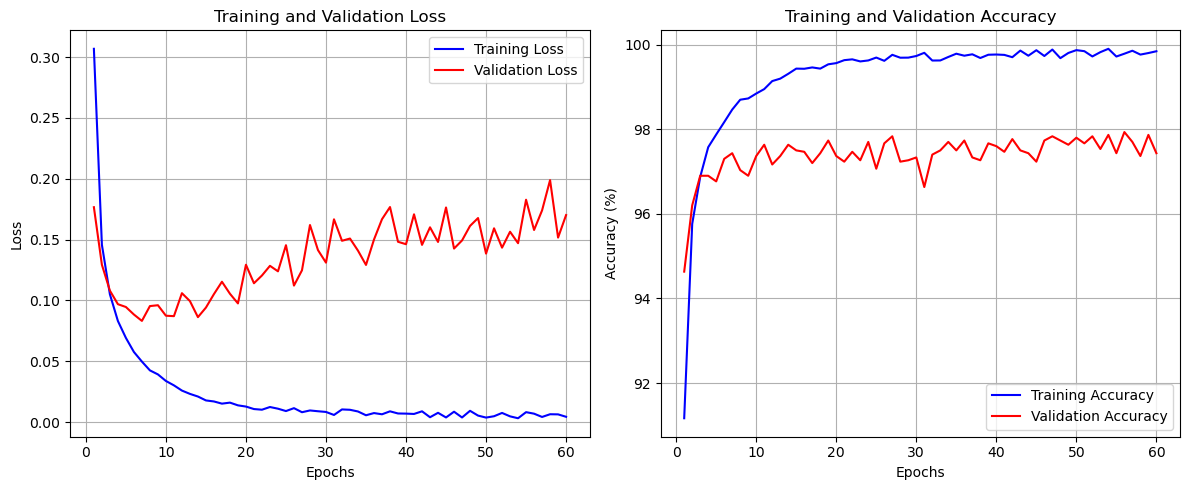

In [44]:
if __name__ == '__main__':
    main()

## Step 8: Main Execution Function forcing underfitting

Epoch [1/10]:
Training Loss: 2.2975, Training Accuracy: 11.78%
Validation Loss: 2.2822, Validation Accuracy: 13.73%
------------------------------------------------------------
Epoch [2/10]:
Training Loss: 2.2661, Training Accuracy: 15.00%
Validation Loss: 2.2513, Validation Accuracy: 17.30%
------------------------------------------------------------
Epoch [3/10]:
Training Loss: 2.2352, Training Accuracy: 18.98%
Validation Loss: 2.2209, Validation Accuracy: 21.42%
------------------------------------------------------------
Epoch [4/10]:
Training Loss: 2.2047, Training Accuracy: 23.75%
Validation Loss: 2.1908, Validation Accuracy: 25.99%
------------------------------------------------------------
Epoch [5/10]:
Training Loss: 2.1744, Training Accuracy: 28.48%
Validation Loss: 2.1611, Validation Accuracy: 30.86%
------------------------------------------------------------
Epoch [6/10]:
Training Loss: 2.1443, Training Accuracy: 33.25%
Validation Loss: 2.1315, Validation Accuracy: 35.65%

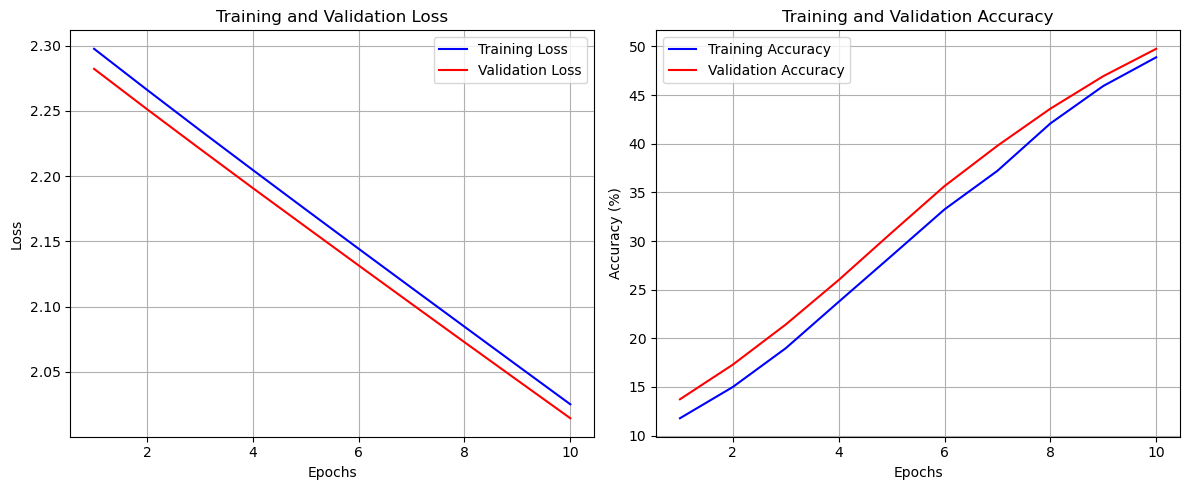

In [45]:
def main_underfitting():
    # Hyperparameters
    batch_size = 16
    learning_rate = 0.000001
    num_epochs = 10

    # Data preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    ])

    # Load MNIST dataset
    full_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

    # Split into training and validation sets (10% train, 90% validation)
    train_size = int(0.1 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize the model, loss function, and optimizer
    model = SimpleNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model and get metrics
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs
    )

    # Plot the results
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

main_underfitting()

## Step 9: Main Execution Function with correct fitting parameters

Epoch [1/10]:
Training Loss: 0.7840, Training Accuracy: 80.91%
Validation Loss: 0.3887, Validation Accuracy: 89.77%
------------------------------------------------------------
Epoch [2/10]:
Training Loss: 0.3380, Training Accuracy: 90.55%
Validation Loss: 0.3059, Validation Accuracy: 91.64%
------------------------------------------------------------
Epoch [3/10]:
Training Loss: 0.2794, Training Accuracy: 92.07%
Validation Loss: 0.2650, Validation Accuracy: 92.60%
------------------------------------------------------------
Epoch [4/10]:
Training Loss: 0.2464, Training Accuracy: 92.99%
Validation Loss: 0.2430, Validation Accuracy: 93.07%
------------------------------------------------------------
Epoch [5/10]:
Training Loss: 0.2215, Training Accuracy: 93.67%
Validation Loss: 0.2229, Validation Accuracy: 93.74%
------------------------------------------------------------
Epoch [6/10]:
Training Loss: 0.2025, Training Accuracy: 94.24%
Validation Loss: 0.2089, Validation Accuracy: 94.10%

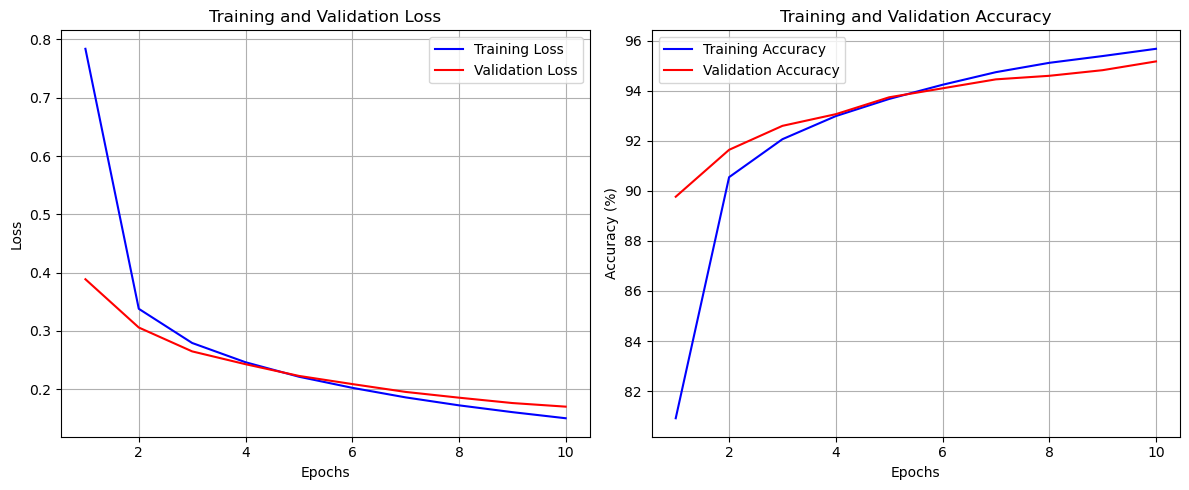

In [47]:
def main_rightfitting():
    # Hyperparameters
    batch_size = 64
    learning_rate = 0.0001
    num_epochs = 10

    # Data preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
    ])

    # Load MNIST dataset
    full_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)

    # Split into training and validation sets (80% train, 20% validation)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize the model, loss function, and optimizer
    model = SimpleNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model and get metrics
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs
    )

    # Plot the results
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

main_rightfitting()